In [1]:
# Download the data set
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-10-31 09:19:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.170.16, 172.217.170.80, 216.58.223.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.170.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  5.80MB/s    in 12s     

2021-10-31 09:19:56 (5.67 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# Install required python packages
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [4]:
# Prepare the dataset
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

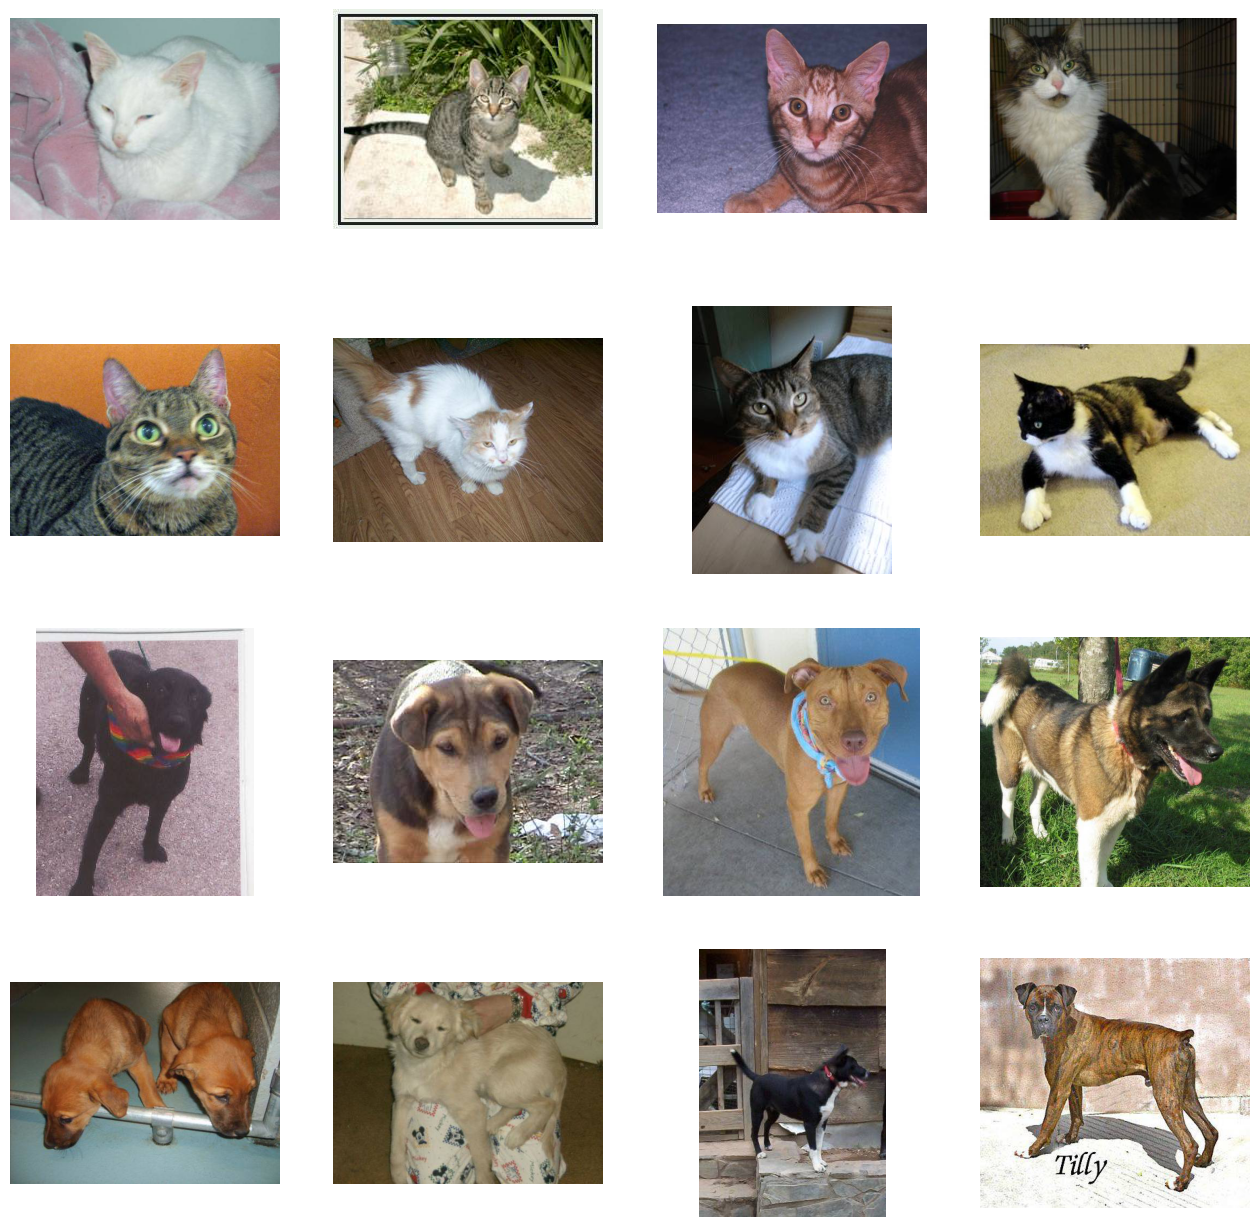

In [5]:
# Validate that images have loaded correctly
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [6]:
# Data Augmentation
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [7]:
# Create Validation Training Splits
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# Install the base Model (VGG16)
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
# base_model = EfficientNetB0(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 10s 0us/step


In [18]:
# Disable non-training layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Change the model for our usecase
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
prediction_layer = layers.Dense(1, activation='softmax')(x)

model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [20]:
# Fit the model on our data
trained_model = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 27s 236ms/step - loss: 0.6648 - acc: 0.6840 - val_loss: 0.3555 - val_acc: 0.8380
Epoch 2/10
100/100 [==============================] - 24s 241ms/step - loss: 0.4776 - acc: 0.7640 - val_loss: 0.3018 - val_acc: 0.8730
Epoch 3/10
100/100 [==============================] - 25s 245ms/step - loss: 0.4278 - acc: 0.7985 - val_loss: 0.3267 - val_acc: 0.8570
Epoch 4/10
100/100 [==============================] - 24s 243ms/step - loss: 0.4066 - acc: 0.8210 - val_loss: 0.2228 - val_acc: 0.9090
Epoch 5/10
100/100 [==============================] - 24s 241ms/step - loss: 0.3668 - acc: 0.8435 - val_loss: 0.2122 - val_acc: 0.9210
Epoch 6/10
100/100 [==============================] - 24s 243ms/step - loss: 0.3546 - acc: 0.8465 - val_loss: 0.2177 - val_acc: 0.9070
Epoch 7/10
100/100 [==============================] - 24s 242ms/step - loss: 0.3315 - acc: 0.8550 - val_loss: 0.2433 - val_acc: 0.9010
Epoch 8/10
100/100 [==============================] - 2